In [1]:
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn import datasets

In [2]:
boston = datasets.load_boston()

/home/bryanhernandez/anaconda3/envs/data/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the C

In [3]:
def rmse(objetivo, estimaciones):
	return np.sqrt(metrics.mean_squared_error(objetivo, estimaciones))

def adjusted_r2(objetivo, estimaciones, n, k):
	r2 = metrics.r2_score(objetivo, estimaciones)
	return 1 - (1-r2)*(n-1) / (n-k-1)

def evaluar_modelo(objetivo, estimaciones, n, k):
	return {
		"rmse": rmse(objetivo, estimaciones),
		"mae": metrics.mean_absolute_error(objetivo, estimaciones),
		"adjusted_r2": adjusted_r2(objetivo, estimaciones, n, k)
	}

In [4]:
modelo_ols = LinearRegression()
modelo_ols.fit(X=boston["data"], y=boston["target"])
modelo_ols_preds = modelo_ols.predict(boston["data"])

In [5]:
RESULTADOS = {}

In [6]:
N = boston["data"].shape[0]

RESULTADOS["ols"] = evaluar_modelo(
	boston["target"],
	modelo_ols_preds,
	N,
	len(modelo_ols.coef_)
)
RESULTADOS

{'ols': {'rmse': 4.679191295697281,
  'mae': 3.2708628109003133,
  'adjusted_r2': 0.733789726372463}}

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
train_test_split?

Signature:
train_test_split(
    *arrays,
    test_size=None,
    train_size=None,
    random_state=None,
    shuffle=True,
    stratify=None,
)
Docstring:
Split arrays or matrices into random train and test subsets.

Quick utility that wraps input validation and
``next(ShuffleSplit().split(X, y))`` and application to input data
into a single call for splitting (and optionally subsampling) data in a
oneliner.

Read more in the :ref:`User Guide <cross_validation>`.

Parameters
----------
*arrays : sequence of indexables with same length / shape[0]
    Allowed inputs are lists, numpy arrays, scipy-sparse
    matrices or pandas dataframes.

test_size : float or int, default=None
    If float, should be between 0.0 and 1.0 and represent the proportion
    of the dataset to include in the test split. If int, represents the
    absolute number of test samples. If None, the value is set to the
    complement of the train size. If ``train_size`` is also None, it will
    be set to 0.25.

train

In [9]:
boston["data"].shape

(506, 13)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
	boston["data"], boston["target"],
	test_size=0.33, random_state=13
)

In [11]:
print(X_train.shape, y_train.shape)

(339, 13) (339,)


In [12]:
print(X_test.shape, y_test.shape)

(167, 13) (167,)


In [13]:
modelo_ols = LinearRegression()
modelo_ols.fit(X=X_train, y=y_train)
modelo_ols_train_preds = modelo_ols.predict(X_train)

In [14]:
RESULTADOS["ols_train"] = evaluar_modelo(
	y_train,
	modelo_ols_train_preds,
	X_train.shape[0],
	len(modelo_ols.coef_)
)

In [15]:
modelo_ols_test_preds = modelo_ols.predict(X_test)

RESULTADOS["ols_test"] = evaluar_modelo(
	y_test,
	modelo_ols_test_preds,
	X_test.shape[0],
	len(modelo_ols.coef_)
)

In [16]:
import pandas as pd

In [17]:
pd.DataFrame(RESULTADOS)

,ols,ols_train,ols_test
rmse,4.679191,4.721732,4.784178
mae,3.270863,3.300868,3.558434
adjusted_r2,0.733790,0.731491,0.688716


Vemos que al sepaarar los datos de entrenamiento y los de test se obtiene un resultado peor al evaluar los datos de test.

Podríamos parar aquí y decir "El error RMSE de mi modelo es 4.787026", y podríamos pensar que está todo bien, ya que no hemos entrenado el modelo en los datos que hemos usado para evaluarlo.

Pero estaríamos en un error, ¿Por qué?

Recuerda que hemos usado un `random_state=13` para la función `train_test_split` que garantiza que la separación de entrenamiento y test sea siempre la misma. Podemos usar cualquier número para este argumento.

Qué pasa si usamos por ejemplo `random_state=42`?

In [18]:
RESULTADOS = {}

X_train, X_test, y_train, y_test = train_test_split(
	boston["data"], boston["target"],
	test_size=0.33, random_state=42
)

modelo_ols = LinearRegression()
modelo_ols.fit(X=X_train, y=y_train)
modelo_ols_train_preds = modelo_ols.predict(X_train)
modelo_ols_test_preds = modelo_ols.predict(X_test)

RESULTADOS["ols_train"] = evaluar_modelo(
	y_train,
	modelo_ols_train_preds,
	X_train.shape[0],
	len(modelo_ols.coef_)
)

RESULTADOS["ols_test"] = evaluar_modelo(
	y_test,
	modelo_ols_test_preds,
	X_test.shape[0],
	len(modelo_ols.coef_)
)

pd.DataFrame(RESULTADOS)

,ols_train,ols_test
rmse,4.794269,4.552365
mae,3.376419,3.148256
adjusted_r2,0.728804,0.702889


El error en los datos de test es menor que en los de entrenamiento, ¿por qué? 

Sencillamente, es porque ha dado la casualidad de que hemos separado los datos de tal forma que los datos de test son muy fáciles de estimar.

Para ver la magnitur del error en el que estamos cayendo al hacer una sola separación entre test y entrenamiento, vamos a provar un montón de semillas y ver cuál es el rango del erro que se puede obtener.

In [19]:
model = LinearRegression();

results = [] 
def test_seed(seed):
	X_train, X_test, y_train, y_test = train_test_split(
		boston["data"], boston["target"],
		test_size=0.33, random_state=seed
	)

	test_preds = model.fit(X=X_train, y=y_train).predict(X_test)
	seed_rmse = rmse(y_test, test_preds)
	results.append([seed_rmse, seed])

In [20]:
for i in range(1000):
	test_seed(i)

In [21]:
results_sorted = sorted(results, key=lambda x: x[0], reverse=False)

In [22]:
results_sorted[0]

[3.6313142170769495, 635]

In [23]:
results_sorted[-1]

[6.788054714003139, 645]

## Validación Cruzada.

Vemos que entre la semilla con menor error de test y la semilla con mayor error hay una diferencia de casi el sobre.

Una forma de evitar el cometer este error es mediante la **Validación cruzada**.

In [24]:
from sklearn.model_selection import cross_val_score

In [25]:
modelo_ols = LinearRegression()
X = boston["data"]
y = boston["target"]

resultados_validacion_cruzada = cross_val_score(
	estimator=modelo_ols,
	X=X,
	y=y,
	scoring="neg_mean_squared_error",
	cv=10
)

In [26]:
resultados_validacion_cruzada

array([  -9.28694671,  -14.15128316,  -14.07360615,  -35.20692433,
        -31.88511666,  -19.83587796,   -9.94726918, -168.37537954,
        -33.32974507,  -10.96041068])

In [27]:
def rmse_cross_val(estimator, X, y):
	y_pred = estimator.predict(X)
	return np.sqrt(metrics.mean_squared_error(y,y_pred))

In [28]:
resultados_cv = []
for i in range(10,200):
	cv_rmse = cross_val_score(
		estimator=modelo_ols,
		X=X,
		y=y,
		scoring=rmse_cross_val,
		cv=i
	).mean()
	resultados_cv.append(cv_rmse)

In [30]:
%matplotlib inline 
import matplotlib.pyplot as plt

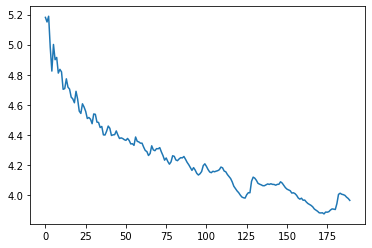

In [31]:
plt.plot(resultados_cv)

In [32]:
from sklearn.model_selection import cross_validate
scoring = {"mae": "neg_mean_absolute_error", "rmse": rmse_cross_val}
estimator = modelo_ols
scores = cross_validate(
	estimator,
	boston["data"], 
	boston["target"],
	scoring=scoring,
	cv=10, 
	return_train_score=False
	)

In [33]:
pd.DataFrame(scores).mean()

fit_time      0.001356
score_time    0.000787
test_mae     -4.004947
test_rmse     5.180846
dtype: float64